#### Don't forget to first create and activate the conda environment.

##### Or the [Docker/Apptainer](../README.md#running-things-in-a-container) if you prefer that instead

The [conda environment](../README.md#creating-the-conda-environment) will install everything you need to run this notebook.

```
conda env create -f environment.yml
conda activate tdc-tcr-epitope-binding-affinity-env
```

#NOTE:
This is not a [Resilience](https://resilience.com) project. The code/opinions/recommendations are mine and mine alone.

# Bioinformatics model for protein therapeutics

We'll use the [Therapeutics Data Commons](https://tdcommons.ai/) Python package to download open-source ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)) datasets that are meaningful in pharmaceutical research. In this notebook, we'll use a dataset called [TCR-Epitope Binding Affinity](https://tdcommons.ai/multi_pred_tasks/tcrepitope/).

![TCR-epitope binding](tcr-epitope-binding.png)

We show how to create a deep learning model for predicting if a T-cell receptor (TCR) and protein epitope will bind to each other. A model that can predict how well a TCR binds to an epitope can lead to more effective treatments that use immunotherapy. For example, in anti-cancer therapies it is important for the T-cell receptor to bind to the protein marker in the cancer cell so that the T-cell (actually the T-cell's friends in the immune system) can kill the cancer cell.

We'll see how to use HuggingFace's [transformers](https://huggingface.co/facebook/esm2_t36_3B_UR50D) package to run state-of-the-art AI models for embedding the protein sequences. In this case, we use Facebook's open-source [Evolutionary Scale Model (ESM-2)](https://github.com/facebookresearch/esm). These embeddings turn the protein sequences into a vector of numbers that the computer can use in a mathematical model. The vector of numbers uniquely encodes (aka embeds) a protein sequence in the same way that the [Dewey Decimal System](https://en.wikipedia.org/wiki/Dewey_Decimal_Classification) and [ISBN](https://en.wikipedia.org/wiki/ISBN) uniquely encode a book into a set of numbers (and letters). This representation is also referred to as a [latent space](https://en.wikipedia.org/wiki/Latent_space#:~:text=A%20latent%20space%2C%20also%20known,another%20in%20the%20latent%20space).

Then, we'll show how to combine this embedding with a simple neural network to create a [binary classifier](https://en.wikipedia.org/wiki/Binary_classification) for the TCR-epitope binding affinity prediction (True="They Bind", False="They don't bind").

![encoder-decoder Dewey Decimal](encoder-decoder.png)


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

## Get the dataset

We are using the TDC dataset for [TCR-Epitope Binding Affinity Prediction Task](https://tdcommons.ai/multi_pred_tasks/tcrepitope/).

From the TDC website:

>T-cells are an integral part of the adaptive immune system, whose survival, proliferation, activation and function are all governed by the interaction of their T-cell receptor (TCR) with immunogenic peptides (epitopes). A large repertoire of T-cell receptors with different specificity is needed to provide protection against a wide range of pathogens. This new task aims to predict the binding affinity given a pair of TCR sequence and epitope sequence.
>
>Weber et al.
Dataset Description: The dataset is from Weber et al. who assemble a large and diverse data from the VDJ database and ImmuneCODE project. It uses human TCR-beta chain sequences. Since this dataset is highly imbalanced, the authors exclude epitopes with less than 15 associated TCR sequences and downsample to a limit of 400 TCRs per epitope. The dataset contains amino acid sequences either for the entire TCR or only for the hypervariable CDR3 loop. Epitopes are available as amino acid sequences. Since Weber et al. proposed to represent the peptides as SMILES strings (which reformulates the problem to protein-ligand binding prediction) the SMILES strings of the epitopes are also included. 50% negative samples were generated by shuffling the pairs, i.e. associating TCR sequences with epitopes they have not been shown to bind.
>
>Task Description: Binary classification. Given the epitope (a peptide, either represented as amino acid sequence or as SMILES) and a T-cell receptor (amino acid sequence, either of the full protein complex or only of the hypervariable CDR3 loop), predict whether the epitope binds to the TCR.
>
>Dataset Statistics: 47,182 TCR-Epitope pairs between 192 epitopes and 23,139 TCRs.
>
>References:
>
> 1. Weber, Anna, Jannis Born, and María Rodriguez Martínez. “TITAN: T-cell receptor specificity prediction with bimodal attention networks.” Bioinformatics 37.Supplement_1 (2021): i237-i244.
>
> 2. Bagaev, Dmitry V., et al. “VDJdb in 2019: database extension, new analysis infrastructure and a T-cell receptor motif compendium.” Nucleic Acids Research 48.D1 (2020): D1057-D1062.
>
> 3. Dines, Jennifer N., et al. “The immunerace study: A prospective multicohort study of immune response action to covid-19 events with the immunecode™ open access database.” medRxiv (2020).
>
>Dataset License: CC BY 4.0.
>
>Contributed by: Anna Weber and Jannis Born.



## Download the TCR-epitope dataset

Download and split randomly into 70% training data, 10% validation data, and 20% testing data.

In [2]:
from tdc.multi_pred import TCREpitopeBinding

In [3]:
data = TCREpitopeBinding(name="weber", path="./data")  # Download the dataset
split = data.get_split(
    method="random", seed=816, frac=[0.7, 0.1, 0.2]
)  # Split the dataset

Found local copy...
Loading...
Done!


In [4]:
print(f"Train dataset size: \t\t{len(split['train']):6,d} proteins")
print(f"Validation dataset size: \t{len(split['valid']):6,d} proteins")
print(f"Test dataset size: \t\t{len(split['test']):6,d} proteins")

Train dataset size: 		33,028 proteins
Validation dataset size: 	 4,718 proteins
Test dataset size: 		 9,436 proteins


In [5]:
train_data = split["train"]
train_data

,epitope_aa,epitope_smi,tcr,tcr_full,label
0,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSVWGTGKTYEQYF,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,1
1,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSVWGEGRSYEQYF,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,1
2,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSATILAGVPYGEQYF,GAVVSQHPSWVICKSGTSVKIECRSLDFQATTMFWYRQFPKQSLML...,1
3,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CASSFDREVTGELFF,GAGVSQTPSNKVTEKGKYVELRCDPISGHTALYWYRQSLGQGPEFL...,1
4,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CASSVGAGTEAFF,DGGITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLI...,1
...,...,...,...,...,...
33023,KLMNIQQKL,CC[C@H](C)[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H...,CASSKPGLTDTQYF,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,0
33024,TLIGDCATV,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,CASSPGQGRTHYGYTF,NAGVTQTPKFRILKIGQSMTLQCAQDMNHNYMYWYRQDPGMGLKLI...,0
33025,LLFGYPVYV,CC(C)C[C@H](N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]...,CASSGGSLNTEAFF,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,0
33026,ISPRTLNAW,CC[C@H](C)[C@H](N)C(=O)N[C@@H](CO)C(=O)N1CCC[C...,CASSPSAAMNTEAFF,TVSWYQQALGQGPQFIFQYYREEENGRGNSPPRFSGLQFPNYSSEL...,0


## What do these columns mean?

The **epitope_aa** and the **tcr_full** columns are the protein (peptide) sequences for the epitope and the T-cell receptor, respectively. The letters correspond to the [standard amino acid codes](https://en.wikipedia.org/wiki/DNA_and_RNA_codon_tables).

The **epitope_smi** column is the [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) notation for the chemical structure of the epitope. We won't use this information. Instead, the ESM-2 embedder should be sufficient for the input to our binary classification model.

The **tcr** column is the CDR3 hyperloop. That's the part of the TCR that actually attaches to the epitope (assuming it binds).

The **label** column is whether the two proteins bind. 0 = No. 1 = Yes.

Our binary classification model should:
* Use the **epitope_aa** and **tcr_full** embeddings as the input
* Make a prediction if the **epitope_aa** and **tcr_full** will bind. This is the classification model's output. (0 = No, 1 = Yes)
* Use the **label** as the ground truth of the binding (i.e. what the scientific experiment says)

## The data is not shuffled

In the original datasets, the rows are sorted by label. We should randomize the row order when training our classification model.

In [6]:
# Randomize row order
train_data = split["train"].sample(frac=1, random_state=816)
validation_data = split["valid"].sample(frac=1, random_state=816)
test_data = split["test"].sample(frac=1, random_state=816)

## Create embedding function

Here we create an embedding function that we can use in the `pandas.apply` method.

## Getting embedding vectors for the protein sequences

HuggingFace provides a "one-stop shop" to train and deploy AI models. In this case, we use Facebook's open-source [Evolutionary Scale Model (ESM-2)](https://github.com/facebookresearch/esm). These embeddings turn the protein sequences into a vector of numbers that the computer can use in a mathematical model.

https://huggingface.co/facebook/esm2_t36_3B_UR50D

**Checkpoint name**|**Number of layers**|**Number of parameters**
:-----:|:-----:|:-----:
esm2\_t48\_15B\_UR50D|	48|	15B
esm2\_t36\_3B\_UR50D|	36|	3B
esm2\_t33\_650M\_UR50D|	33|	650M
esm2\_t30\_150M\_UR50D|	30|	150M
esm2\_t12\_35M\_UR50D|	12|	35M
esm2\_t6\_8M\_UR50D|	6|	8M

The Facebook ESM-2 model has the MIT license and was published in:

> Zeming Lin et al, Evolutionary-scale prediction of atomic-level protein structure with a language model, Science (2023). DOI: 10.1126/science.ade2574  https://www.science.org/doi/10.1126/science.ade2574

We're using the smaller ESM2 model simply because it won't take as long to complete the embedding. However, if you have the time, then try to see if the larger ESM2 models will give you and boost in performance.

In [7]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using GPU = {torch.cuda.is_available()}")

Using GPU = True


In [12]:
from transformers import AutoTokenizer, AutoModel

# model_name = "facebook/esm2_t36_3B_UR50D"  # 3 billion parameter model, embedding size 2560
model_name = (
    "facebook/esm2_t6_8M_UR50D"  # 8 million parameter model, embedding size 320
)
#model_name = "facebook/esm2_t33_650M_UR50D"
esm_tokenizer = AutoTokenizer.from_pretrained(model_name)

esm_model = AutoModel.from_pretrained(model_name)
esm_model = esm_model.to(device=device)
esm_model.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

In [13]:
def get_embeddings(sequence, model, tokenizer):
    """
    Compute embeddings for each token in the sequence

    Args:
       sequence (str): The input protein sequence
       model: The HuggingFace model
       tokenizer: The HuggingFace tokenizer

    Returns:
      numpy.ndarray: A matrix where each row is the embedding of a token in the sequence
    """

    inputs = tokenizer(
        sequence, return_tensors="pt", truncation=True, padding=True, max_length=1024
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Return embeddings after removing CLS and EOS tokens.
    # Only take the mean of the sequence so that all embeddings are the same length
    # i.e. Otherwise they would be a 2D array where the first dimension is sequence length
    return outputs.last_hidden_state[:, 1:-1, :].squeeze(0).mean(0).cpu().numpy()

In [14]:
# Sequence from: https://www.uniprot.org/uniprot/P58426
sequence = "DDCGKLFSGCDTNADCCEGYVCRLWCKLDW"
embedding = get_embeddings(sequence, esm_model, esm_tokenizer)

print(f"The sequence length is {len(sequence)}")
print(f"The shape of each embedding vector is: {np.shape(embedding)}")

The sequence length is 30
The shape of each embedding vector is: (320,)


In [15]:
def get_all_embeddings(epitope_sequence: str, tcr_sequence: str, cdr3_sequence: str):
    """Calculate embeddings for different parts of the protein sequences"""

    epitope_embedding = get_embeddings(epitope_sequence, esm_model, esm_tokenizer)
    tcr_embedding = get_embeddings(tcr_sequence, esm_model, esm_tokenizer)
    cdr3_embedding = get_embeddings(cdr3_sequence, esm_model, esm_tokenizer)

    return pd.Series([epitope_embedding, tcr_embedding, cdr3_embedding])

## Get embedding for the protein sequences

Returns the embedding vectors for the **epitope** and **tcr**. We'll use these embeddings as input to our model.

### Embedding speed

It takes over 2 hours to embed the training dataset using an NVidia RTX2000 Ada generation with model `esm2_t33_650M_UR50D` (650M parameters). The smaller `esm2_t6_8M_UR50D` (8M parameter) model takes about 30 minutes.

#### Pre-trained embeddings

The embeddings can take a long time to process. You can skip this step by downloading my pre-calculated ones from [Zenodo](https://zenodo.org/records/11894560).

In [16]:
os.makedirs(model_name, exist_ok=True)   # Create a directory to save the embeddings

In [17]:
tqdm.pandas(
    desc="Embedding protein sequences"
)  # Create fancy progress bar for Pandas apply

In [18]:
training_data_filename = os.path.join(model_name, "train_data.pkl")
if not os.path.exists(training_data_filename):
    train_data[["epitope_vector", "tcr_vector", "cd3r_vector"]] = (
        train_data.progress_apply(
            lambda x: get_all_embeddings(x["epitope_aa"], x["tcr_full"], x["tcr"]),
            axis="columns",
            result_type="expand",
        )
    )

    train_data.to_pickle(training_data_filename)
else:
    print("Loading previously saved train dataset embeddings.")
    train_data = pd.read_pickle(training_data_filename)

Embedding protein sequences:   0%|          | 0/33028 [00:00<?, ?it/s]

In [19]:
validation_data_filename = os.path.join(model_name, "validation_data.pkl")
if not os.path.exists(validation_data_filename):
    validation_data[["epitope_vector", "tcr_vector", "cd3r_vector"]] = (
        validation_data.progress_apply(
            lambda x: get_all_embeddings(x["epitope_aa"], x["tcr_full"], x["tcr"]),
            axis="columns",
            result_type="expand",
        )
    )
    validation_data.to_pickle(validation_data_filename)
else:
    print("Loading previously saved validation dataset embeddings.")
    validation_data = pd.read_pickle(validation_data_filename)

Embedding protein sequences:   0%|          | 0/4718 [00:00<?, ?it/s]

In [20]:
test_data_filename = os.path.join(model_name, "test_data.pkl")
if not os.path.exists(test_data_filename):
    test_data[["epitope_vector", "tcr_vector", "cd3r_vector"]] = (
        test_data.progress_apply(
            lambda x: get_all_embeddings(x["epitope_aa"], x["tcr_full"], x["tcr"]),
            axis="columns",
            result_type="expand",
        )
    )
    test_data.to_pickle(test_data_filename)
else:
    print("Loading previously saved test dataset embeddings.")
    test_data = pd.read_pickle(test_data_filename)

Embedding protein sequences:   0%|          | 0/9436 [00:00<?, ?it/s]

### Let's look at our new dataframe with the protein embeddings

In [21]:
train_data

,epitope_aa,epitope_smi,tcr,tcr_full,label,epitope_vector,tcr_vector,cd3r_vector
11113,LVLSVNPYV,CC(C)C[C@H](N)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)...,CASGAPSYEQYF,DAGITQSPRYKITETGRQVTLMCHQTWSHSYMFWYRQDLGHGLRLI...,1,"[0.038534015, -0.32389918, 0.3308991, 0.134337...","[-0.28208765, -0.14748743, -0.099499434, 0.044...","[0.10006699, -0.24881284, 0.16725007, 0.158485..."
27246,RLRPGGKKR,CC(C)C[C@H](NC(=O)[C@@H](N)CCCNC(=N)N)C(=O)N[C...,CASSLLAGDFSYNEQFF,GAGVSQSPRYKVTKRGQDVALRCDPISGHVSLYWYRQALGQGPEFL...,0,"[-0.0021749537, -0.5705189, 0.34297302, 0.6072...","[-0.2839003, -0.14871292, 0.082863465, 0.05347...","[0.07825382, -0.25411108, 0.16184156, 0.093944..."
32541,TLDSKTQSL,CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=...,CSVGWRQNTEAFF,TIQCQVDSQVTMIFWYRQQPGQSLTLIATANQGSEATYESGFVIDK...,0,"[0.12294577, -0.2256919, 0.22606874, 0.0216736...","[-0.17999662, -0.13155857, 0.03158948, -0.1171...","[0.077383354, -0.26157582, 0.23503162, 0.17523..."
2925,GILGFVFTL,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](CC(C)C)C...,CASKARGSPLHF,EAQVTQNPRYLITVTGKKLTVTCSQNMNHEYMSWYRQDPGLGLRQI...,1,"[0.1166945, -0.12083704, 0.19408055, 0.1212016...","[-0.34745646, -0.15962036, -0.021790126, 0.139...","[0.03470412, -0.3783253, 0.13022633, 0.2472901..."
8283,ITEEVGHTDLMAAY,CC[C@H](C)[C@H](N)C(=O)N[C@H](C(=O)N[C@@H](CCC...,CASSQGPGGDGELFF,HLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLS...,1,"[0.17735769, -0.085576214, 0.23910408, 0.02161...","[-0.29679978, -0.19048814, 0.009169238, 0.1410...","[0.083958775, -0.39204308, 0.22613832, 0.13092..."
...,...,...,...,...,...,...,...,...
11255,KLSYGIATV,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](Cc1ccc(O)cc...,CASSRDYNTGELFF,TAGITQAPTSQILAAGRSMTLRCTQDMRHNAMYWYRQDLGLGLRLI...,1,"[0.107314385, -0.15555699, 0.24414475, 0.14851...","[-0.23373993, -0.13337035, 0.007332661, -0.028...","[0.07891652, -0.24792679, 0.14765465, 0.163737..."
19674,SFHSLHLLF,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,CASSPRGSGESTDTQYF,HLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLS...,0,"[-0.041375518, -0.39945617, 0.21541002, 0.1111...","[-0.30409825, -0.21730398, -0.065790065, 0.147...","[0.060847964, -0.36856344, 0.088047996, 0.1679..."
15677,WICLLQFAY,CC[C@H](C)[C@H](NC(=O)[C@@H](N)Cc1c[nH]c2ccccc...,CASSAGTGGITDTQYF,DAEITQSPRHKITETGRQVTLACHQTWNHNNMFWYRQDLGHGLRLI...,1,"[0.03950087, -0.3644118, 0.22049274, 0.2395057...","[-0.28494298, -0.17834686, 0.03679241, -0.0048...","[0.14439249, -0.15367289, 0.07951622, 0.108295..."
164,LLQTGIHVRVSQPSL,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H...,CSASLDSGTQETQYF,GAVVSQHPSWVICKSGTSVKIECRSLDFQATTMFWYRQFPKQSLML...,1,"[0.09716663, -0.35961112, 0.27731243, 0.097459...","[-0.3185343, -0.1504636, 0.018437518, -0.01153...","[0.06731486, -0.2654356, 0.16570343, 0.0855510..."


In [22]:
test_data[["epitope_vector", "tcr_vector", "cd3r_vector", "label"]]

,epitope_vector,tcr_vector,cd3r_vector,label
1966,"[0.11756068, -0.17726119, 0.21559499, 0.226084...","[-0.2496988, -0.14253776, 0.040706888, 0.08691...","[0.07543397, -0.30791205, 0.15727155, 0.087190...",0
9408,"[0.21328215, -0.06046487, 0.269702, 0.00173665...","[-0.32340783, -0.2267902, -0.012520636, 0.0924...","[0.04712369, -0.27774197, 0.14300615, 0.160680...",0
3168,"[0.06054182, -0.31700128, 0.38526642, 0.282358...","[-0.26972562, -0.15555282, -0.044835523, 0.055...","[0.10473794, -0.22698924, 0.1669027, 0.1547409...",0
956,"[0.031733107, -0.38563797, 0.22444288, 0.13873...","[-0.2774681, -0.18532652, 0.059007324, 0.01290...","[0.10494517, -0.25884837, 0.15787368, 0.101360...",1
5034,"[0.16600582, -0.32457992, 0.3533009, 0.1887973...","[-0.2218102, -0.102710515, 0.027087376, 0.0079...","[-0.0027738106, -0.1857487, 0.064010814, 0.176...",1
...,...,...,...,...
3290,"[0.109696895, -0.31173432, 0.3281438, 0.103866...","[-0.33872184, -0.18544455, 0.03181725, 0.09333...","[0.06117232, -0.3019955, 0.2630141, 0.169023, ...",1
5774,"[0.046975505, -0.2649276, 0.23652273, 0.294588...","[-0.2833794, -0.21230242, 0.044284813, -0.0083...","[0.060584165, -0.23498924, 0.14196908, 0.11568...",1
164,"[0.015819773, 0.0018905882, 0.29173946, 0.1501...","[-0.2566507, -0.14838167, 0.09135117, 0.015357...","[0.042209413, -0.29709765, 0.21791954, 0.23540...",0
5373,"[0.107314385, -0.15555699, 0.24414475, 0.14851...","[-0.27858907, -0.11695308, 0.06962588, 0.06203...","[0.1383814, -0.20685391, 0.13446483, 0.1321696...",1


### We want to merge the input vectors

We have 2 inputs for our model: **epitope_vector** and **tcr_vector**. We have many choices of how to use these in the model. 

There's no real "right" way to put them together so let's just merge the epitope and TCR vectors into a single vector. 

This will be the input to our binary classification model.

You can try any modifications you want if you don't like to concatenate them.

In [23]:
train_data["input"] = train_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)
validation_data["input"] = validation_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)
test_data["input"] = test_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)

### Pull out the X and y datasets

In [24]:
X_train = train_data["input"]
y_train = train_data["label"]

X_validation = validation_data["input"]
y_validation = validation_data["label"]

X_test = test_data["input"]
y_test = test_data["label"]

### We should scale the input data

[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) just removes the mean and normalizes by the standard deviation. It's usually a good idea for pre-processing the input dataset.

In [25]:
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(train_data["input"].to_list())

ss_validation = StandardScaler()
X_validation = ss_validation.fit_transform(validation_data["input"].to_list())

ss_test = StandardScaler()
X_test = ss_test.fit_transform(test_data["input"].to_list())

### Use XGBoost to create binary classifier

[XGBoost](https://xgboost.readthedocs.io/en/stable/get_started.html) is a good Python library to train models using Gradient Boosted Trees. We'll use this to create our binary classifier. If you have a GPU, then you can add the `tree_method="gpu_hist"` parameter. Training on the GPU takes only seconds. Training on the CPU takes ~6 minutes.

NOTE: Scikit-learn is another good choice for training models. However, I found that it took ~ 45 minutes to train a SVM classifier and the results weren't any better.

In [26]:
from xgboost import XGBClassifier

from torch import cuda

if cuda.is_available():  # GPU is available to use
    print("Using GPU acceleration")
    clf = XGBClassifier(
        tree_method="gpu_hist", random_state=816, verbosity=2
    )  # If GPU is available
else:  # No GPU
    clf = XGBClassifier(random_state=816, verbosity=1)

Using GPU acceleration


### Train the model

In [27]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=816, ...)

### Evaluate how the model performs on unseen data

We'll print out the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). These are calculated on the test_data. The model was never trained on the test_data so it is a good approximation of how the model will perform on future unseen data.

In [28]:
CLASS_NAMES = ["No bind", "Bind"]

In [29]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

In [30]:
predictions_gradient = clf.predict(X_test)

print(classification_report(y_test, predictions_gradient, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

     No bind       0.73      0.75      0.74      4708
        Bind       0.75      0.72      0.74      4728

    accuracy                           0.74      9436
   macro avg       0.74      0.74      0.74      9436
weighted avg       0.74      0.74      0.74      9436



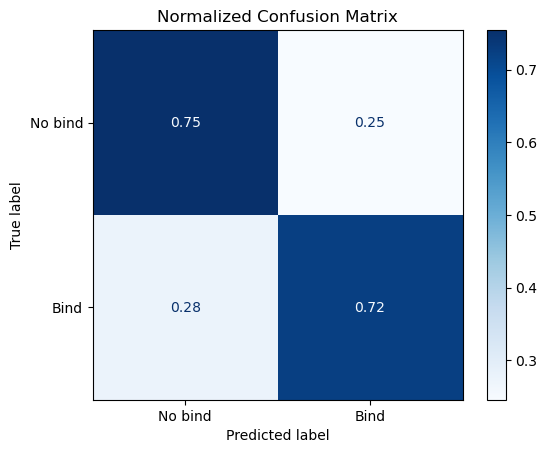

In [31]:
# creating a confusion matrix
cm_norm = confusion_matrix(y_test, predictions_gradient, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues")

disp.ax_.set_title("Normalized Confusion Matrix")
disp.ax_.grid(False)